In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat

In [2]:
# defyining function which allows changing the bar width.
# solution by jsgounot (https://stackoverflow.com/users/5016055/jsgounot)
def set_bar_width(ax, new_width):
    for patch in ax.patches:
        current_width = patch.get_width()
        patch.set_width(new_width)
        diff = current_width - new_width
        patch.set_x(patch.get_x() + diff * .5)

In [3]:
# importing data from the file
# data are asigned to list, which will serve as a base for creating dataframe

all_genes_data = SeqIO.parse("orf_genomic.fasta", "fasta")

gene_ID = []
chromosome = []
gene_length = []
base_content = [[],[],[],[],[]]

bases = ['A', 'T', 'C', 'G']
for seq_record in all_genes_data:
    gene_ID.append(seq_record.id)
    try:
        chromosome.append(seq_record.description.split('Chr ')[1].split(' ')[0]) # extracting chromosome number
    except IndexError:
        chromosome.append('no data')
    gene_length.append(len(seq_record))
    for index, base in enumerate(bases):
        base_content[index].append(round((seq_record.seq).count(base) / len(seq_record)*100, 2))

In [4]:
# creating dataframe

all_genes_df = pd.DataFrame()
all_genes_df['gene_ID'] = gene_ID
all_genes_df['chromosome'] = chromosome
all_genes_df['gene_length[bp]'] = gene_length
for index, base in enumerate(bases):
    all_genes_df[base+'_content[%]'] = base_content[index]
all_genes_df.head()

,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%]
0,YAL001C,I,3573,35.32,27.60,15.81,21.27
1,YAL002W,I,3825,31.90,30.93,18.75,18.43
2,YAL003W,I,987,29.69,31.10,18.84,20.36
3,YAL005C,I,1929,29.13,26.80,21.15,22.91
4,YAL007C,I,648,30.86,32.10,17.59,19.44


The all_genes_df dataframe contains gene ID, gene lenght and % content of each nucleotyde. Let's check if nucleotyde content sums up to 100% for every gene

In [5]:
all_genes_df['total_check'] = all_genes_df.loc[:, 'A_content[%]' : 'G_content[%]'].sum(axis=1)
all_genes_df.groupby('total_check')['gene_ID'].count()

total_check
99.99       26
99.99      466
99.99      460
100.00     246
100.00    3483
100.00     254
100.01     480
100.01     482
100.01      20
Name: gene_ID, dtype: int64

All values are very cloe to 100%, the differences are at 0.01 level which is probably a result of round() function used when importing data.

In [6]:
all_genes_df.drop('total_check', axis=1, inplace=True) # removing 'total_check column'

Now let's some quick charts to see how gene lenghts nad bases contents are distributed in yeast genes and if there are any correlation between gene lengths and bases contents.

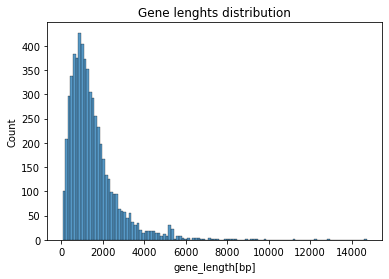

In [7]:
sns.histplot(all_genes_df['gene_length[bp]'])
plt.title('Gene lenghts distribution')
plt.show()

Gene lenghts ranges up to approx. 15000 base pairs, however only few of them are longer than 5000. Most of them have lenght of around 1000-1500 base pairs.

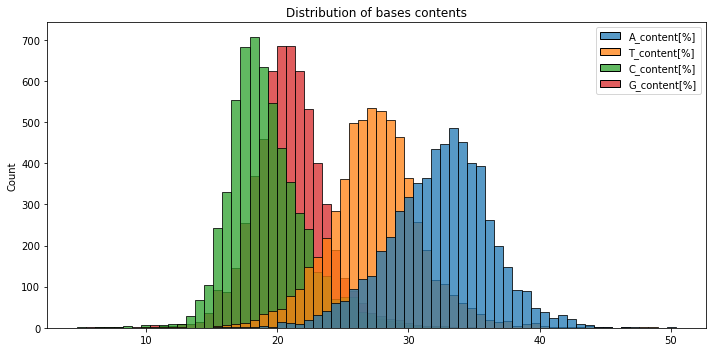

In [8]:
data = all_genes_df.loc[:, 'A_content[%]' : 'G_content[%]']
fig, ax = plt.subplots()
fig.set_size_inches([10, 5])
sns.histplot(data)
plt.title('Distribution of bases contents')
plt.tight_layout()
plt.show()

The charts shows that adenine content is the highest in yeast genes (mostly between 25% and 40%). The lowest is guanine (mostly 15%-25%)

For geneticists, an interesting parameter is content of GC pairs. GC pairs have three hydrogen bonds, while AT two, so physical properties of DNA encoding genes are different depending on GC content - the more GC pairs, the more energy is required for separation of DNA strands. Let's see if there is some correlation between GC content and gene lenght. I calculate average GC content and label genes as these which are above and below average GC content.

In [9]:
all_genes_df['GC_content[%]'] = all_genes_df.loc[:, 'C_content[%]' : 'G_content[%]'].sum(axis=1)
all_genes_df

,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%],GC_content[%]
0,YAL001C,I,3573,35.32,27.60,15.81,21.27,37.08
1,YAL002W,I,3825,31.90,30.93,18.75,18.43,37.18
2,YAL003W,I,987,29.69,31.10,18.84,20.36,39.20
3,YAL005C,I,1929,29.13,26.80,21.15,22.91,44.06
4,YAL007C,I,648,30.86,32.10,17.59,19.44,37.03
...,...,...,...,...,...,...,...,...
5912,Q0275,Mito,810,30.12,39.88,13.83,16.17,30.00
5913,R0010W,no data,1272,35.69,27.28,17.61,19.42,37.03
5914,R0020C,no data,1122,33.33,26.83,16.76,23.08,39.84
5915,R0030W,no data,546,29.67,30.40,20.88,19.05,39.93


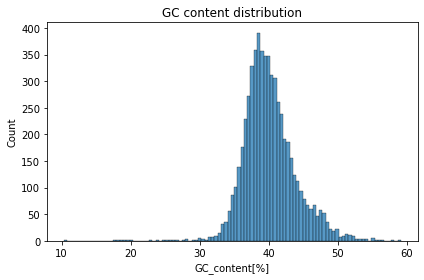

In [10]:
sns.histplot(all_genes_df['GC_content[%]'])
plt.title('GC content distribution')
plt.tight_layout()
plt.show()

GC content for most of the genes ranges from 30 to 50%, significantly peaking around 40%. The distribution is slightly skewed to the higher values

It would be interesting to see if GC content is somehow correlated with gene length. To visualise that, a scatter plot showing relations between GC content and gene lenght will be suitable. Medians for both values are indicated

In [11]:
# defining medians for GC content and gene length
GC_median = all_genes_df['GC_content[%]'].median()
lenght_median = all_genes_df['gene_length[bp]'].median()

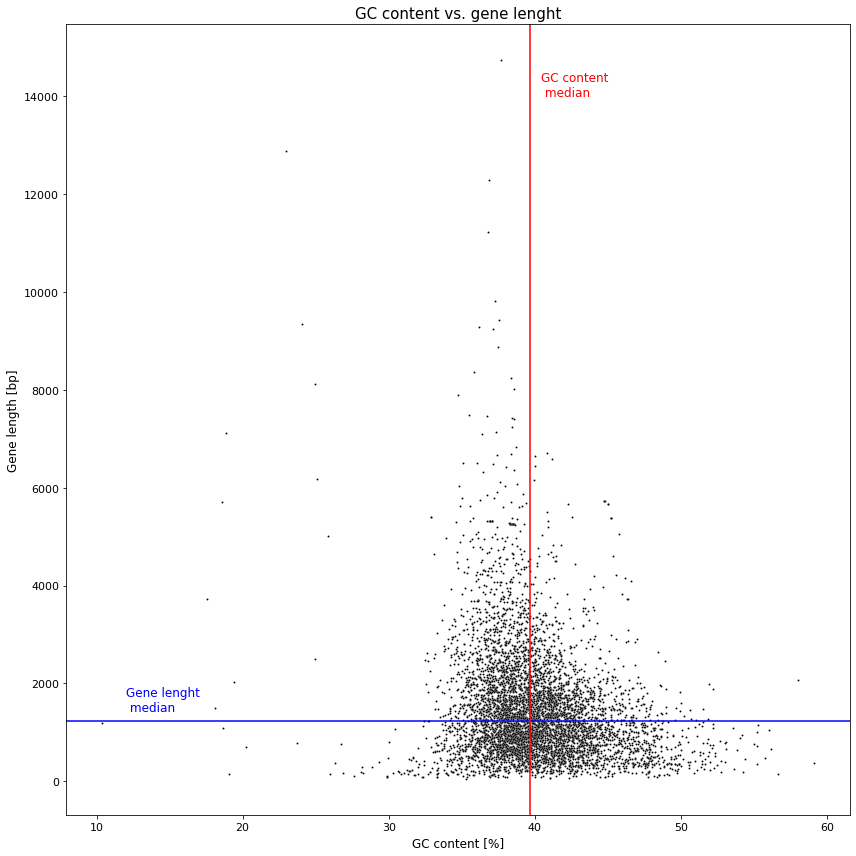

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches([12,12])

ax = sns.scatterplot(data=all_genes_df, x="GC_content[%]", y='gene_length[bp]', s=4, color='black')

ax.set_title('GC content vs. gene lenght', fontsize=15)
ax.set_xlabel('GC content [%]', fontsize=12)
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=11)
ax.set_ylabel('Gene length [bp]', fontsize=12)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=11)


ax.axhline(lenght_median, c='b')
ax.text(12, lenght_median + 200, 'Gene lenght \n median', c='b', fontsize=12)
ax.axvline(GC_median, c='r')
ax.text(GC_median + 0.75, 14000, 'GC content \n median', c='r', fontsize=12)
plt.tight_layout()
plt.show()

While there is no clear corelation between GC content and gene length and most of the genes localize around the intersection point of both medians, an interesting phenomenon is visiible - longer genes (above 2000 bp) tend to have GC content lower than the median. The longer a gene is, the more is likely that its content is below the median. There are not genes longer than 7000 bp with GC content above the median. Reverse tendency is observed for short genes - genes below gene lenght median tend to have higher GC content. Perhapse, it will be possible to create a ML model predicting GC content based on gene lenth (or vice versa).

Interestingly, there are a few genes with low GC content which significantly stand out from the "main body". It would be interesting to find out see if they are just occasional outliers or maybe there is a feature which unites them. Let's check if these outliers are located on a particular chromosome

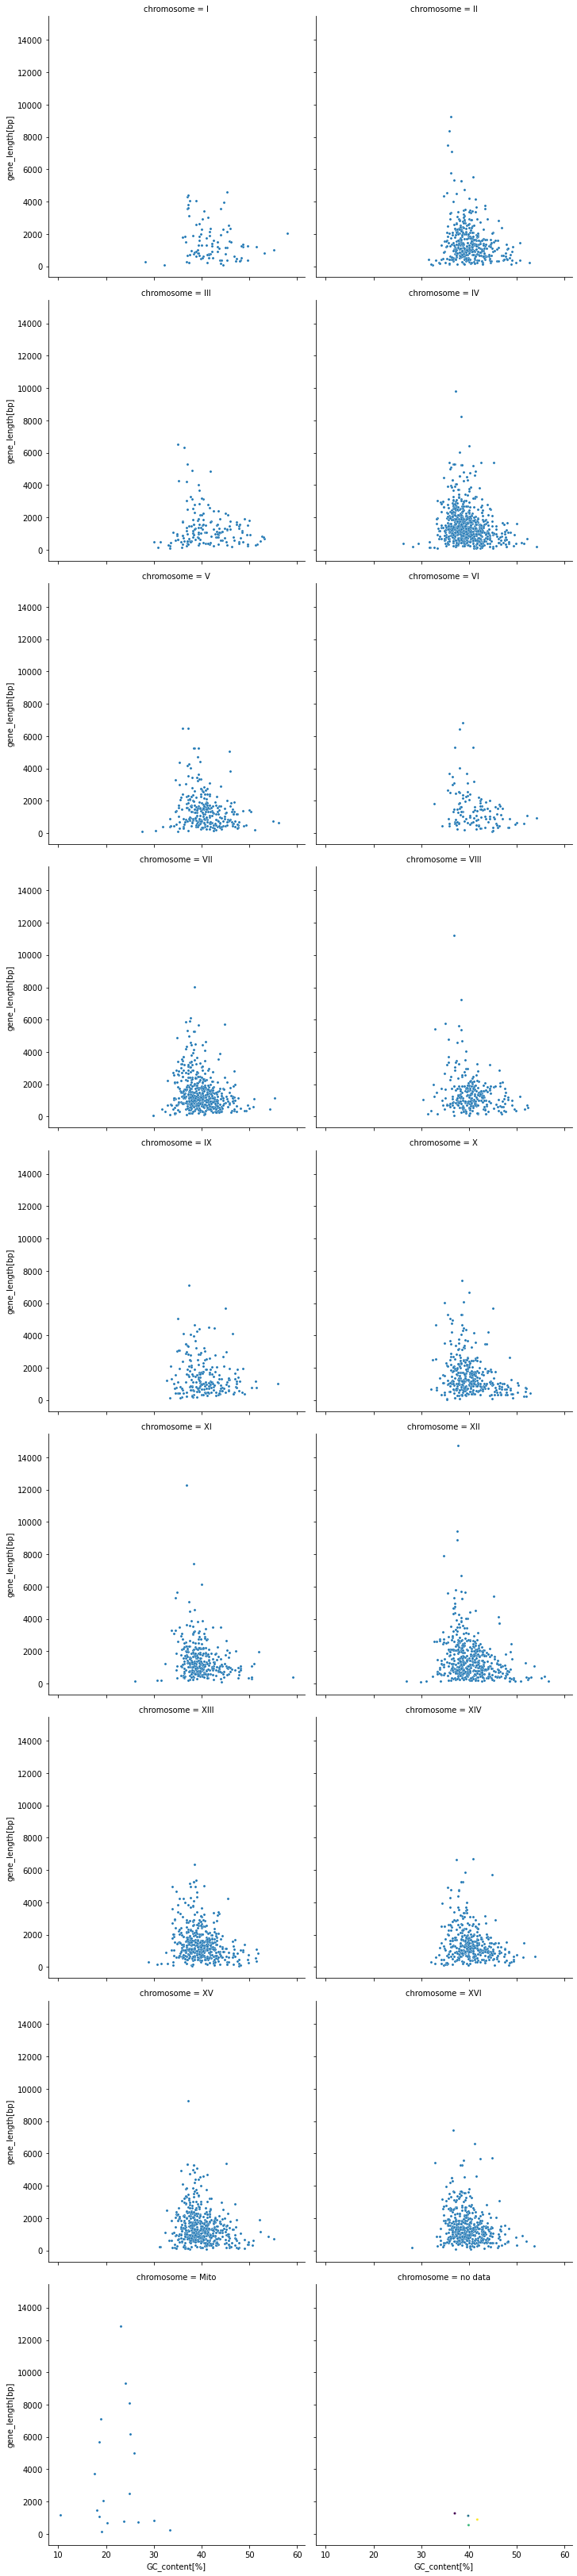

In [13]:
sns.relplot(data=all_genes_df, x="GC_content[%]", y='gene_length[bp]', col='chromosome', col_wrap=2, s=10)
plt.show()

Bingo! Most of the outliers are located on the mitochondrial chromosome. Despite it is probably an elegant indicator of endosymbiotic mitochondrial origin, these genes will likely disturb performance of ML models. Let's focus on nuclear genom and remove mitochondrially encoded genes, same as genes with unasigned chromosomes, from our dataset.

The relation between GC content and gene length is similar on the nuclear chromosomes, except the chromosome I, which has a distinct pattern, which points at higher GC content in genes located on this chromosome. However, number of genes on the chromosome I is quite low, therefore it's more likely to observe higher deviations.

In [14]:
# removing mitochondrial and not assigned to chromosome genes

print('number of rows before dropping:', len(all_genes_df))
all_genes_df.drop(all_genes_df[all_genes_df['chromosome'].isin(['Mito', 'no data'])].index, inplace=True)
print('number of rows after dropping:', len(all_genes_df))

number of rows before dropping: 5917
number of rows after dropping: 5894


Just one more check if we have only nuclear chromosomes

In [15]:
all_genes_df['chromosome'].unique()

array(['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI',
       'XII', 'XIII', 'XIV', 'XV', 'XVI'], dtype=object)

Looks fine.

Now, let's assign genes to categories telling, if there are below or above each of the medians. This will allow to visialise data using barplot counting how many genes are in each category. This will further tell if our prediction based on the previous scatter plot were true.

In [16]:
# setting conditions for categories: below/above GC content/gene length medians)

condition1 = (all_genes_df['GC_content[%]'] <= GC_median) & (all_genes_df['gene_length[bp]'] <= lenght_median)
condition2 = (all_genes_df['GC_content[%]'] > GC_median) & (all_genes_df['gene_length[bp]'] <= lenght_median)
condition3 = (all_genes_df['GC_content[%]'] <= GC_median) & (all_genes_df['gene_length[bp]'] > lenght_median)
condition4 = (all_genes_df['GC_content[%]'] > GC_median) & (all_genes_df['gene_length[bp]'] > lenght_median)

# adding a category column to the all_genes_df using np.select function
condition_list = [condition1, condition2, condition3, condition4]
choice_list = ['GC content below \n length below', 'GC content above \n length below', 'GC content below \n lenght above', 'GC content above \n lenght above']
all_genes_df['category'] = np.select(condition_list, choice_list, default=0)

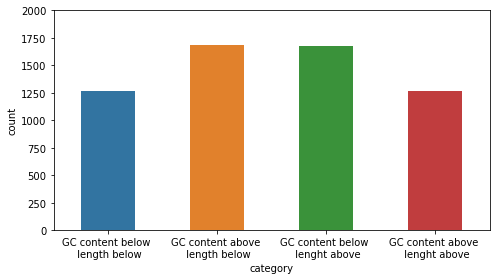

In [17]:
# creating a countplot
fig, ax = plt.subplots()
fig.set_size_inches([7, 4])
ax = sns.countplot(x= all_genes_df['category'], order=choice_list)
set_bar_width(ax, 0.5)
ax.set_ylim(0,2000)

plt.tight_layout()
plt.show()

In [18]:
# counting the share of each category
all_genes_df['category'].value_counts(normalize=True)

GC content above \n length below    0.286563
GC content below \n lenght above    0.284187
GC content above \n lenght above    0.214795
GC content below \n length below    0.214455
Name: category, dtype: float64

The count plot shows confirm our previous observations - when a gene lenght is below the median, more genes have GC content above the median, and when a gene length is above the median, more genes have GC content below the median.

To check if observed results are statistically significant, I perform a chi-squared test.

In [19]:
counted = all_genes_df['category'].value_counts()
stat.chisquare(counted)

Power_divergenceResult(statistic=118.07872412623007, pvalue=2.000732902697445e-25)

P-value is extremely low (9.6 * 10^-26). This means that assigning to categories are not idependent. In other words, observed differences between categories are not caused by a coincidence, and there is another reason behind these result. One can tell that longer genes tend to have lower GC content, and shorter genes tend to have higher GC content.

In [20]:
inviable_genes = []
with open('inviable_genes.txt') as file:
    for line in file:
        line_index_0 = line.split('\t')[0]
        if line_index_0[0] == 'Y':
            inviable_genes.append(line_index_0)

In [21]:
len(inviable_genes)

1184

In [22]:
viable_genes = []
with open('viable_genes.txt', encoding="utf8") as file:
    for line in file:
        line_index_0 = line.split('\t')[0]
        if line_index_0[0] == 'Y':
            viable_genes.append(line_index_0)

In [23]:
len(viable_genes)

4870

In [24]:
ambiguous_genes = list(set(inviable_genes) & set(viable_genes))
len(ambiguous_genes)

111

In [25]:
rows_to_drop = all_genes_df['gene_ID'].isin(ambiguous_genes)

In [26]:
all_genes_df = all_genes_df[~rows_to_drop]

In [27]:
is_inviable = all_genes_df['gene_ID'].isin(inviable_genes)
is_viable = all_genes_df['gene_ID'].isin(viable_genes)
condition_list = [is_inviable, is_viable]
categories = ['yes', 'no']
all_genes_df['is_essential'] = np.select(condition_list, categories, default='unknown')

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [28]:
all_genes_df

,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%],GC_content[%],category,is_essential
0,YAL001C,I,3573,35.32,27.60,15.81,21.27,37.08,GC content below \n lenght above,yes
1,YAL002W,I,3825,31.90,30.93,18.75,18.43,37.18,GC content below \n lenght above,no
2,YAL003W,I,987,29.69,31.10,18.84,20.36,39.20,GC content below \n length below,yes
3,YAL005C,I,1929,29.13,26.80,21.15,22.91,44.06,GC content above \n lenght above,no
4,YAL007C,I,648,30.86,32.10,17.59,19.44,37.03,GC content below \n length below,no
...,...,...,...,...,...,...,...,...,...,...
5889,YPR200C,XVI,393,32.82,29.52,15.78,21.88,37.66,GC content below \n length below,no
5890,YPR201W,XVI,1215,27.74,34.49,17.53,20.25,37.78,GC content below \n length below,no
5891,YPR202W,XVI,865,31.56,29.94,18.73,19.77,38.50,GC content below \n length below,unknown
5892,YPR203W,XVI,309,29.77,28.16,19.74,22.33,42.07,GC content above \n length below,unknown


In [29]:
rows_to_drop = all_genes_df['is_essential'] == 'unknown'
all_genes_df = all_genes_df[~rows_to_drop]

In [30]:
all_genes_df['is_essential'].unique()

array(['yes', 'no'], dtype=object)

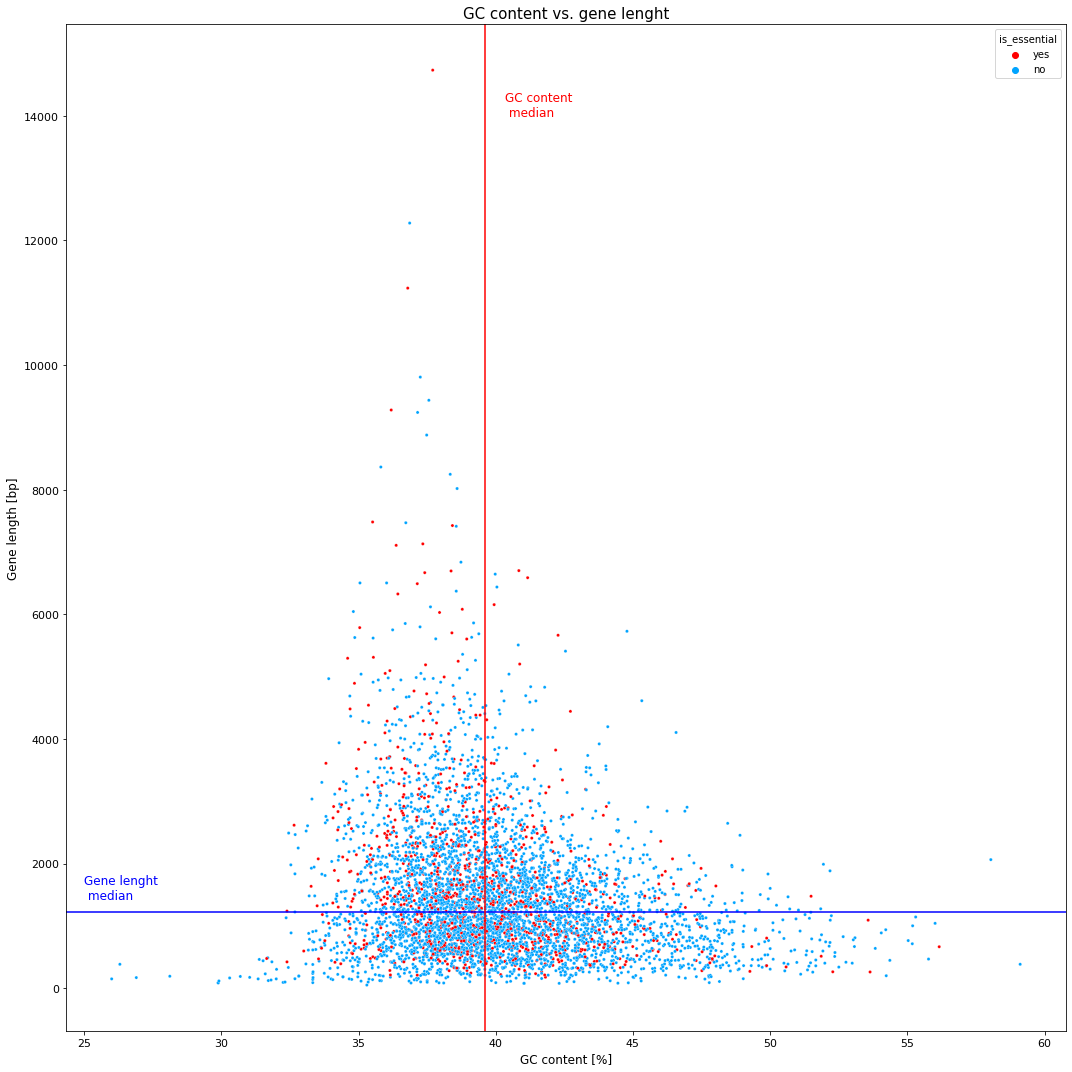

In [31]:
GC_median = all_genes_df['GC_content[%]'].median()
lenght_median = all_genes_df['gene_length[bp]'].median()
fig, ax = plt.subplots()
fig.set_size_inches([15, 15])

colors = ['#FF0000', '#00A4FF']

ax = sns.scatterplot(data=all_genes_df, x="GC_content[%]", y='gene_length[bp]', hue='is_essential',
                     palette=colors, s=10)

ax.set_title('GC content vs. gene lenght', fontsize=15)
ax.set_xlabel('GC content [%]', fontsize=12)
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=11)
ax.set_ylabel('Gene length [bp]', fontsize=12)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=11)


ax.axhline(lenght_median, c='b')
ax.text(25, lenght_median + 200, 'Gene lenght \n median', c='b', fontsize=12)
ax.axvline(GC_median, c='r')
ax.text(GC_median + 0.75, 14000, 'GC content \n median', c='r', fontsize=12)
plt.tight_layout()
plt.show()

In [32]:
all_genes_df.groupby('category')['category'].count()

category
GC content above \n lenght above    1124
GC content above \n length below    1493
GC content below \n lenght above    1541
GC content below \n length below    1159
Name: category, dtype: int64

In [33]:
condition_list = [condition1, condition2, condition3, condition4]
ratio_list = []

In [34]:
condition_list = [condition1, condition2, condition3, condition4]
ratio_list = []
for condition in condition_list:
    table = all_genes_df[condition]
    ratio = len(table[table['is_essential'] == 'yes'])/len(table)
    ratio_list.append(ratio)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [35]:
condition_list = [condition1, condition2, condition3, condition4]
ratio_list = []
for condition in condition_list:
    table = all_genes_df[condition]
    ratio = len(table[table['is_essential'] == 'yes'])/len(table)
    ratio_list.append(ratio)
ratio_list

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


[0.17860224331320104,
 0.1607501674480911,
 0.23556132381570408,
 0.17526690391459074]

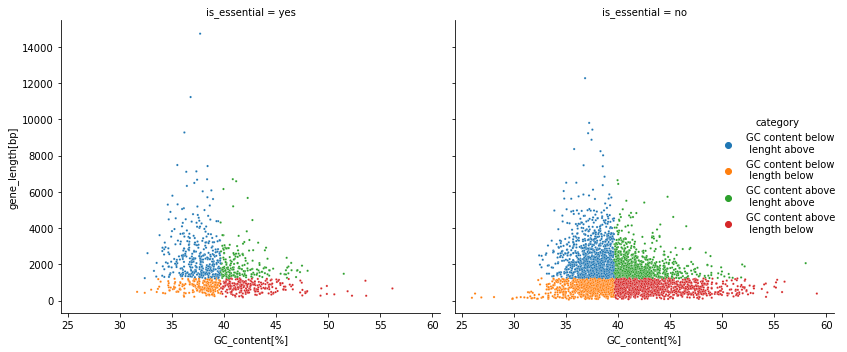

In [36]:
g = sns.relplot(data=all_genes_df, x="GC_content[%]", y='gene_length[bp]',
                col='is_essential', hue='category', s=5)

# ax.set_title('GC content vs. gene lenght', fontsize=15)
# ax.set_xlabel('GC content [%]', fontsize=12)
# ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=11)
# ax.set_ylabel('Gene length [bp]', fontsize=12)
# ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=11)


# g.hline(lenght_median, c='b')
# # ax.text(12, lenght_median + 200, 'Gene lenght \n median', c='b', fontsize=12)
# g.vline(GC_median, c='r')
# ax.text(GC_median + 0.75, 14000, 'GC content \n median', c='r', fontsize=12)
plt.tight_layout()
plt.show()

In [37]:
all_genes_df['category'].value_counts(normalize=True).sort_index()

GC content above \n lenght above    0.211397
GC content above \n length below    0.280797
GC content below \n lenght above    0.289825
GC content below \n length below    0.217980
Name: category, dtype: float64

In [38]:
all_genes_df[all_genes_df['is_essential'] == 'yes']['category'].value_counts(normalize=True).sort_index()

GC content above \n lenght above    0.195631
GC content above \n length below    0.238332
GC content below \n lenght above    0.360477
GC content below \n length below    0.205561
Name: category, dtype: float64

In [39]:
all_genes_df[all_genes_df['is_essential'] == 'no']['category'].value_counts(normalize=True).sort_index()

GC content above \n lenght above    0.215081
GC content above \n length below    0.290719
GC content below \n lenght above    0.273318
GC content below \n length below    0.220882
Name: category, dtype: float64

In [40]:
yes = all_genes_df[all_genes_df['is_essential'] == 'yes'].groupby('chromosome')['is_essential'].count()
all_counts = all_genes_df.groupby('chromosome')['is_essential'].count()

In [41]:
yes / all_counts

chromosome
I       0.151899
II      0.168421
III     0.102190
IV      0.216450
IX      0.186170
V       0.176230
VI      0.247525
VII     0.205451
VIII    0.158590
X       0.196875
XI      0.204013
XII     0.193059
XIII    0.160550
XIV     0.202186
XV      0.181263
XVI     0.200957
Name: is_essential, dtype: float64

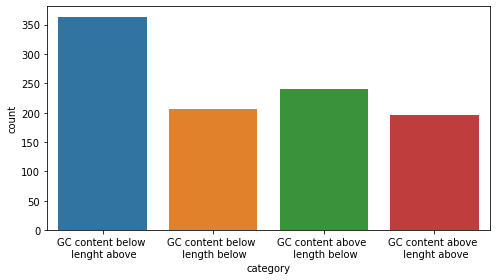

In [42]:
# creating a countplot
fig, ax = plt.subplots()
fig.set_size_inches([7, 4])
data = all_genes_df[all_genes_df['is_essential']=='yes']
ax = sns.countplot(data=data, x='category')
# set_bar_width(ax, 0.5)
# ax.set_ylim(0,2000)

plt.tight_layout()
plt.show()

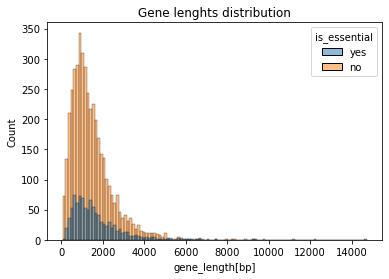

In [43]:
sns.histplot(data=all_genes_df, x= 'gene_length[bp]', hue='is_essential')
plt.title('Gene lenghts distribution')
plt.show()

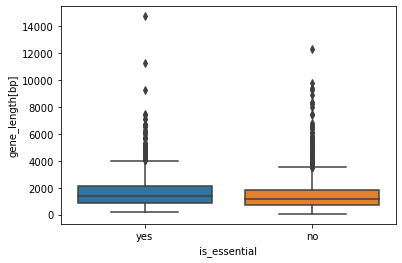

In [44]:
sns.boxplot(data=all_genes_df, x='is_essential', y= 'gene_length[bp]')
plt.show()

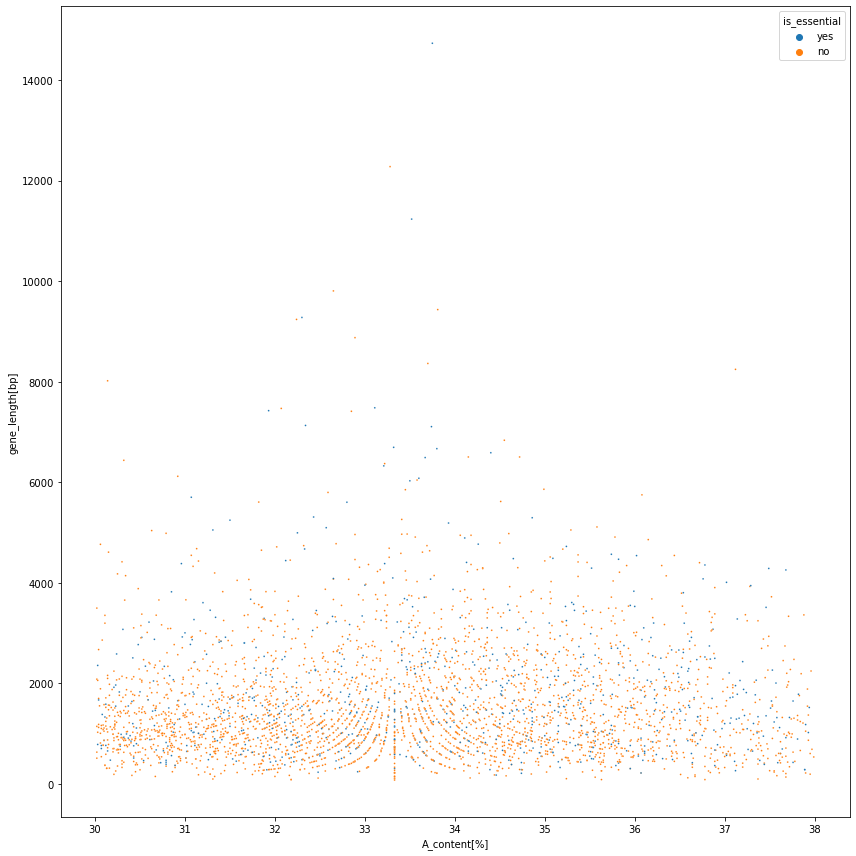

In [46]:
nucleotyde_median = all_genes_df['A_content[%]'].median()
lenght_median = all_genes_df['gene_length[bp]'].median()
data = all_genes_df[(all_genes_df['A_content[%]'] > 30) & (all_genes_df['A_content[%]'] < 38)]



fig, ax = plt.subplots()
fig.set_size_inches([12,12])

ax = sns.scatterplot(data=data, x='A_content[%]', y='gene_length[bp]', s=3, color='black', hue='is_essential')

# ax.set_title('GC content vs. gene lenght', fontsize=15)
# ax.set_xlabel('GC content [%]', fontsize=12)
# ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=11)
# ax.set_ylabel('Gene length [bp]', fontsize=12)
# ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=11)


# ax.axhline(lenght_median, c='b')
# ax.text(12, lenght_median + 200, 'Gene lenght \n median', c='b', fontsize=12)
# ax.axvline(nucleotyde_median, c='r')
# ax.text(GC_median + 0.75, 14000, 'GC content \n median', c='r', fontsize=12)
plt.tight_layout()
plt.show()